<a href="https://colab.research.google.com/github/Irina-64/AML-22_ZAK-9/blob/main/CrispDM_wine_quality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Понимание бизнеса

## 1.1 Цель
Классифицировать португальские вина «Vinho Verde» как "плохие", "нормальные" или "отличные"

## 1.2 Описание
Данные были загружены из репозитория машинного обучения UCI.

Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». Подробнее см. в ссылке [Cortez et al., 2009]. Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем отличных или плохих). Алгоритмы обнаружения выбросов можно использовать для определения нескольких отличных или плохих вин.

[Описание от Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

## 2. Понимание данных

### 2.1. Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from pprint import pprint

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

### 2.2 Вспомогательные функции

In [ ]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

### 2.3. Загрузка данных

данные можно найти [здесь](https://github.com/Irina-64/AML-22_FEML-9/blob/input/winequalityN.csv)  или на гуглдрайв

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_wine = pd.read_csv("/content/drive/MyDrive/ААД/Семинары/С2_Блокноты/winequalityN.csv")

### 2.4 Статистика и визуализации

In [ ]:
df_wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
df_wine.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


**Описание переменных** (по данным физико-химических тестов):
- 1 - fixed acidity (большинство кислот, связанных с вином, либо фиксированные, либо нелетучие (легко не испаряются))
- 2 - volatile acidity (количество уксусной кислоты в вине, которая при слишком высоком уровне может привести к неприятному "уксусному" вкусу)
- 3 - citric acid (Лимонная кислота, содержащаяся в небольших количествах, может придать вину «свежесть» и аромат)
- 4 - residual sugar (количество сахара, оставшееся после прекращения брожения, редко можно найти вина с содержанием сахара менее 1 г/л, а вина с содержанием сахара более 45 г/л считаются сладкими)
- 5 - chlorides (количество соли в вине)
- 6 - free sulfur dioxide (свободная форма SO^2 (диоксида серы) существует в равновесии между молекулярным SO^2 (в виде растворенного газа) и бисульфит-ионом; предотвращает рост микробов и окисление вина)
- 7 - total sulfur dioxide (количество свободных и связанных форм диоксида серы; при низких концентрациях диоксида серы практически не обнаруживается в вине, но при концентрациях свободного диоксида серы более 50 частей на миллион диоксида серы становится заметным в аромате и вкусе вина)
- 8 - density (плотность воды близка к плотности воды в зависимости от процентного содержания спирта и сахара)
- 9 - pH (описывает, насколько кислым или щелочным является вино по шкале от 0 (очень кислое) до 14 (очень щелочное); большинство вин имеют рН от 3 до 4 по шкале pH)
- 10 - sulphates (добавка к вину, которая может способствовать повышению уровня газообразного диоксида серы (SO2), действующая как антимикробное и антиоксидантное средство)
- 11 - alcohol (процент содержания алкоголя в вине)
Целевая переменная (по данным сенсорной оценки):
12 - quality (целевая переменная (на основе сенсорных данных, оценка от 0 до 10))

(Больше информации на сайте [Kaggle](https://www.kaggle.com/rajyellow46/wine-quality) )

### 2.5 Далее взглянем на некоторую ключевую информацию о переменных
<p>Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип вина.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.


In [ ]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


#### 2.6 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

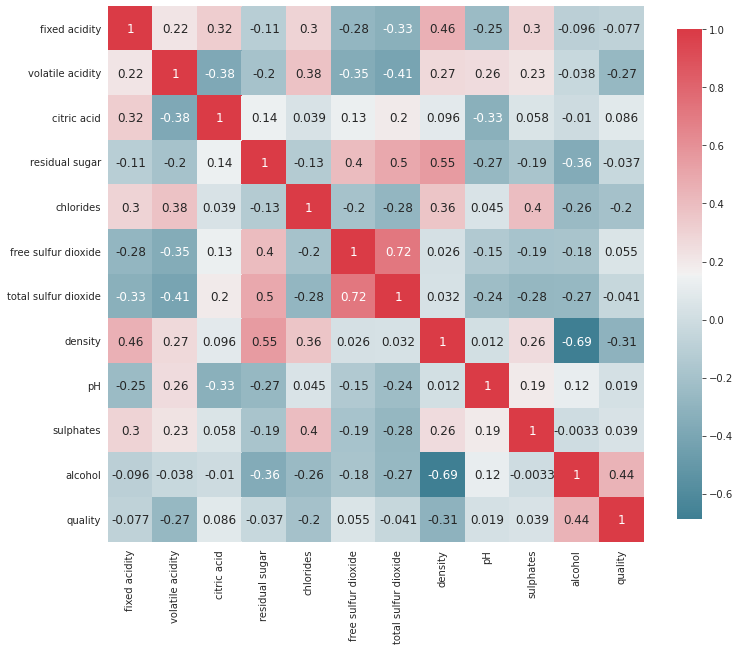

In [ ]:
plot_correlation_map( df_wine )

# 3. Предобработка

Сначала посмотрим, сколько пропущенных значений в датасете:

In [ ]:
total_entries = (df_wine.shape[0] * df_wine.shape[1])
missing_entries_max = df_wine.isnull().sum().sum()
missing_entries_max_percentage = (missing_entries_max / total_entries) * 100

print(f"Total entries in the dataset: %i" % total_entries)
print(f"Maximum missing values in the dataset: {missing_entries_max}")
print(f"Percentage of maximum missing values in the dataset: {missing_entries_max_percentage:.2f}%")
df_wine

Total entries in the dataset: 84461
Maximum missing values in the dataset: 38
Percentage of maximum missing values in the dataset: 0.04%


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Поскольку процент отсутствующих записей незначителен, мы можем отбросить каждое наблюдение, содержащее нуль, не влияя на точность прогноза.

In [ ]:
df_wine = df_wine.dropna(axis=0)
df_wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Теперь мы по порядку закодируем категорию «type»:

In [ ]:
df_wine = df_wine.replace('red', 0)
df_wine = df_wine.replace('white', 1)

Теперь построим гистограммы для каждой переменной:

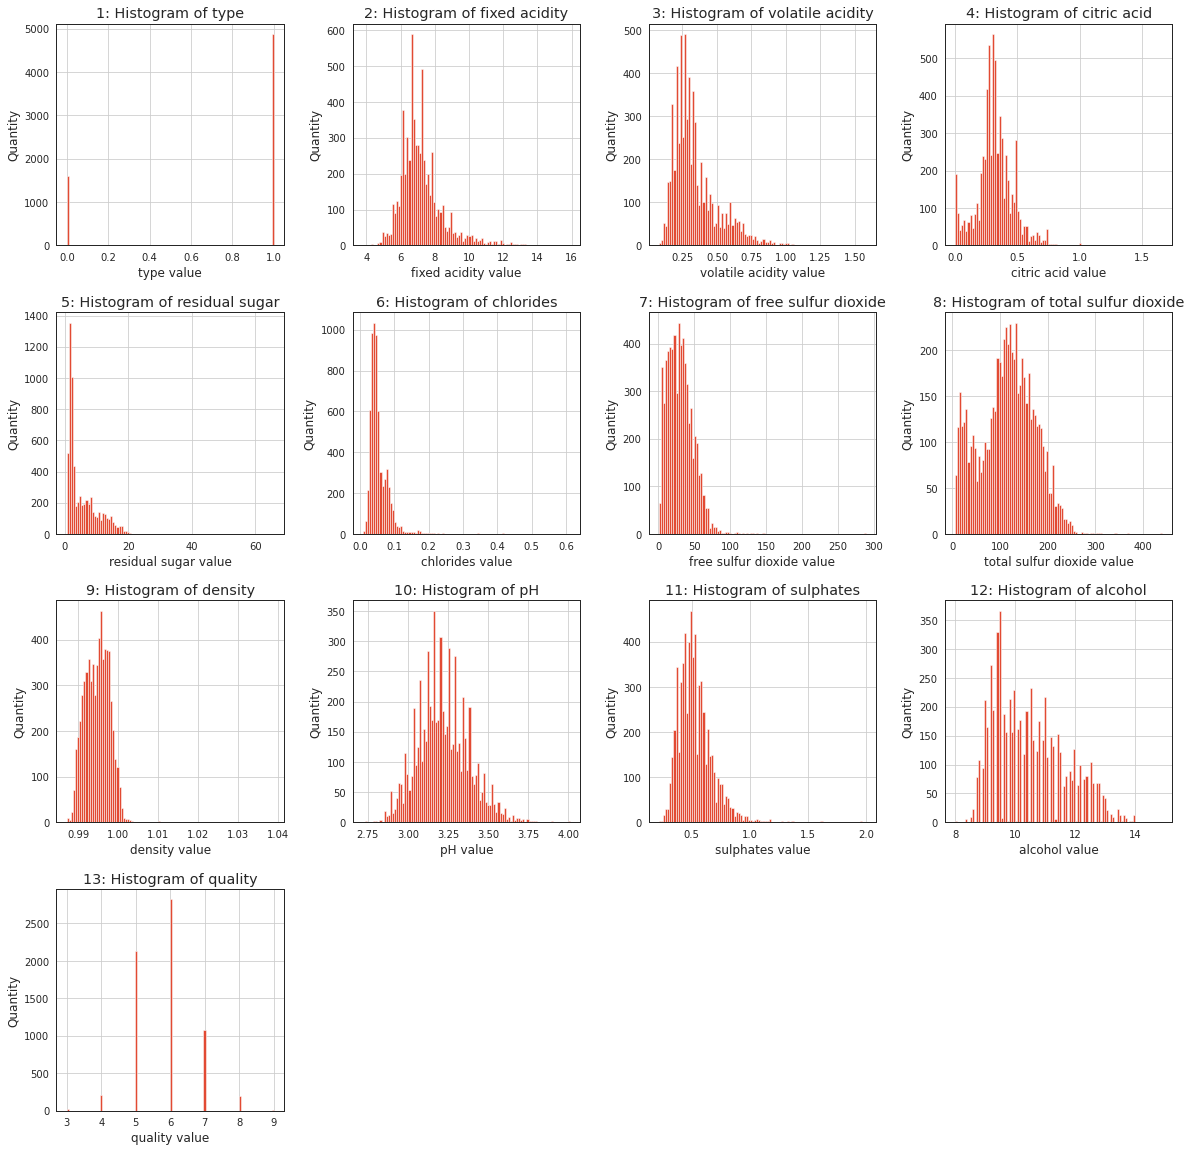

In [ ]:
axarr = df_wine.hist(bins = 100, figsize = (20, 20))
i=1
for ax in axarr.flatten():
    ax.set_xlabel(f"{ax.get_title()} value")
    ax.set_ylabel("Quantity")
    title = ax.get_title() 
    ax.set_title(f"%d: Histogram of {title}" % (i)) 
    i=i+1
plt.show()

В частности, мы покажем гистограмму целевой переменной "quality", и посмотрим, что является наиболее распространенным показателем качества в наборе данных.

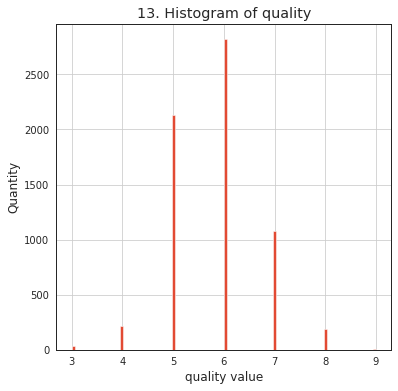

In [ ]:
axarr = df_wine.hist(column=['quality'], bins=100, figsize=(6, 6))

ax = axarr.flatten()[0]
ax.set_xlabel(f"{ax.get_title()} value")
ax.set_ylabel("Quantity")
title = ax.get_title()
ax.set_title(f"13. Histogram of {title}")

plt.show()

Очевидно, наибольшая частота появления у значения  '6', а наименьшая - '3', и максимальная оценка качества - '9'.
В общем, мы можем видеть, что большинство переменных (кроме признака «тип», которая является бинарным параметром) нормально распределены. 

Попробуем оценить корелляцию признаков на тепловой карте

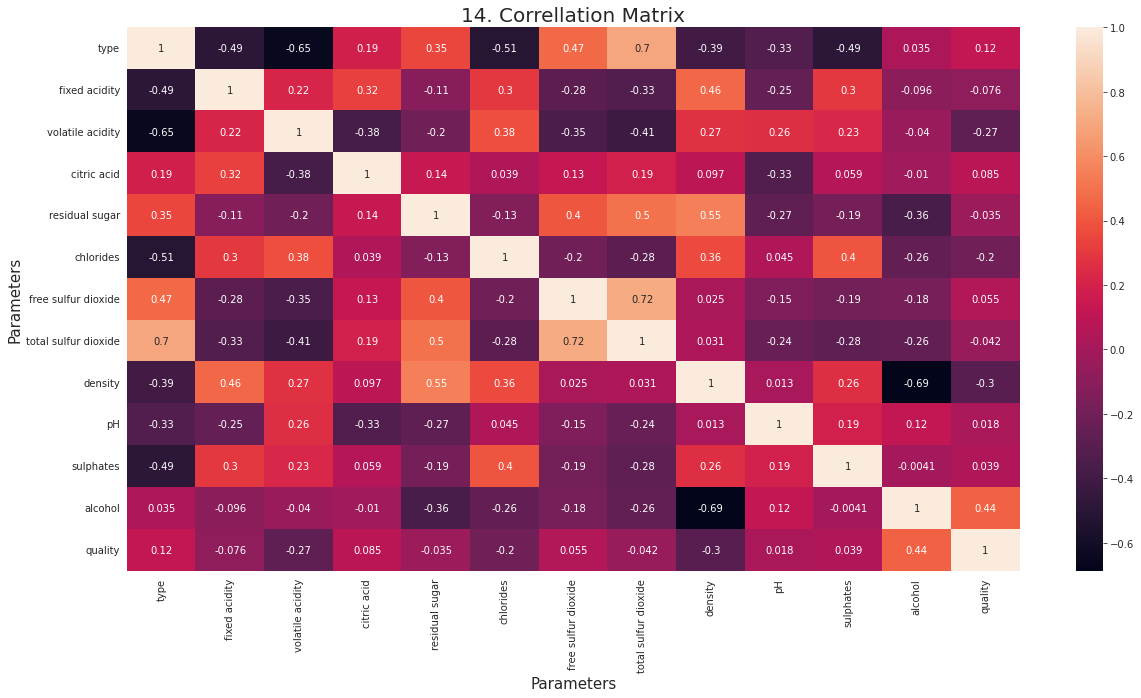

In [ ]:
plt.figure(figsize = (20, 10))
sns.heatmap(df_wine.corr(), annot = True)
plt.title('14. Correllation Matrix', fontsize = 20)
plt.xlabel('Parameters', fontsize = 15) 
plt.ylabel('Parameters', fontsize = 15) 
plt.show()

Сделаем гипотезу о том, что если между двумя разными параметрами существует корреляция выше 0.7,то она достаточно высока, поэтому мы можем удалить одну из переменных. Поэтому мы решили убрать переменную 'total sulfur dioxide' (общий диоксид серы).

In [ ]:
data = df_wine.drop('total sulfur dioxide',axis=1)
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.270,0.36,20.7,0.045,45.0,1.00100,3.00,0.45,8.8,6
1,1,6.3,0.300,0.34,1.6,0.049,14.0,0.99400,3.30,0.49,9.5,6
2,1,8.1,0.280,0.40,6.9,0.050,30.0,0.99510,3.26,0.44,10.1,6
3,1,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.40,9.9,6
4,1,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6491,0,6.8,0.620,0.08,1.9,0.068,28.0,0.99651,3.42,0.82,9.5,6
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,0.99490,3.45,0.58,10.5,5
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,0.99574,3.42,0.75,11.0,6
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,0.99547,3.57,0.71,10.2,5


In [ ]:
data = pd.get_dummies(data, drop_first=True)
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.270,0.36,20.7,0.045,45.0,1.00100,3.00,0.45,8.8,6
1,1,6.3,0.300,0.34,1.6,0.049,14.0,0.99400,3.30,0.49,9.5,6
2,1,8.1,0.280,0.40,6.9,0.050,30.0,0.99510,3.26,0.44,10.1,6
3,1,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.40,9.9,6
4,1,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6491,0,6.8,0.620,0.08,1.9,0.068,28.0,0.99651,3.42,0.82,9.5,6
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,0.99490,3.45,0.58,10.5,5
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,0.99574,3.42,0.75,11.0,6
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,0.99547,3.57,0.71,10.2,5


Теперь заметим, что, поскольку наш набор данных несбалансирован (т.е. есть параметры, которые имеют большие диапазоны по сравнению с другими), мы нормализуем каждую функцию, чтобы она находилась в диапазоне [0, 1].

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

In [ ]:
scaler = MinMaxScaler()
data_fit = scaler.fit(data)
data_fit = data_fit.transform(data)

# Reconstructing the dataset
data = pd.DataFrame(data_fit, columns=['type', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','density','pH','sulphates','alcohol','quality'])
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.267785,0.217054,0.129213,0.115942,0.5
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.132832,0.449612,0.151685,0.217391,0.5
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.154039,0.418605,0.123596,0.304348,0.5
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.163678,0.364341,0.101124,0.275362,0.5
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.163678,0.364341,0.101124,0.275362,0.5


### 4. Разбиение данных на train и test части

In [ ]:
X = data[['type', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','density','pH','sulphates','alcohol']]
y = data.quality

# 80% train set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# 5. Моделирование
## 5.1 Разработка и обучение модели на основе 6 экспериментов

Во-первых, давайте введем следующую функцию, которая вычисляет RMSE между тестовыми и прогнозируемыми значениями:

In [ ]:
def get_rmse(y_test, predictions):
    return mean_squared_error(y_test, predictions) ** 0.5

В следующих 6 экспериментах мы проверяем взаимосвязь между каждым параметром модели RandomForestRegressor и RMSE, обучая 10-20 моделей в каждом эксперименте с одинаковыми параметрами, кроме параметра, который мы хотим проверить. Затем каждая модель делает прогнозы, которые затем оцениваются функцией get_rmse().

### Experiment #1: 'n_estimators'

RMSE of model with n_estimators=50: 0.10626
RMSE of model with n_estimators=100: 0.10542
RMSE of model with n_estimators=150: 0.10524
RMSE of model with n_estimators=200: 0.10495
RMSE of model with n_estimators=250: 0.10481
RMSE of model with n_estimators=300: 0.10474
RMSE of model with n_estimators=350: 0.10465
RMSE of model with n_estimators=400: 0.10456
RMSE of model with n_estimators=450: 0.10442
RMSE of model with n_estimators=500: 0.10445


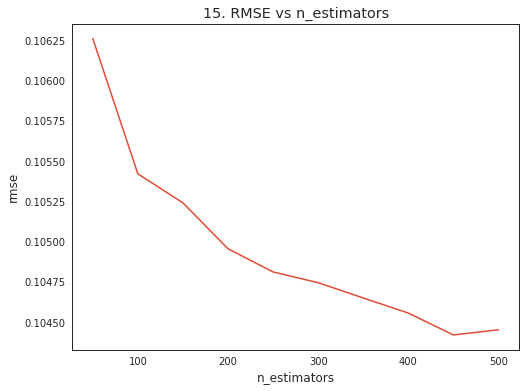

In [ ]:
# Creating the 10 models
n_estimators = [50 + i*50 for i in range(10)]
models_n_estimators = [RandomForestRegressor(n_estimators = n_estimators[i], random_state = 42) for i in range(10)]

n_estimators_rmses = []
   
# Fitting the models and making predictions    
for model in models_n_estimators:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    n_estimators_rmses += [rmse]
    print(f"RMSE of model with n_estimators={model.n_estimators}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(n_estimators, n_estimators_rmses)
plt.title("15. RMSE vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("rmse")
plt.show()

### Experiment #2: 'max_depth'

RMSE of model with max_depth=10: 0.11103
RMSE of model with max_depth=20: 0.10525
RMSE of model with max_depth=30: 0.10539
RMSE of model with max_depth=40: 0.10542
RMSE of model with max_depth=50: 0.10542
RMSE of model with max_depth=60: 0.10542
RMSE of model with max_depth=70: 0.10542
RMSE of model with max_depth=80: 0.10542
RMSE of model with max_depth=90: 0.10542
RMSE of model with max_depth=100: 0.10542


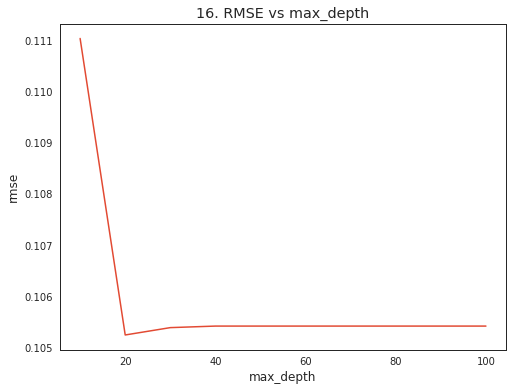

In [ ]:
# Creating the 10 models
max_depths = [10 + i*10 for i in range(10)]
models_max_depths = [RandomForestRegressor(max_depth = max_depths[i], random_state = 42) for i in range(10)]

max_depths_rmses = []

# Fitting the models and making predictions
for model in models_max_depths:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    max_depths_rmses += [rmse]
    print(f"RMSE of model with max_depth={model.max_depth}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(max_depths, max_depths_rmses)
plt.title("16. RMSE vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("rmse")
plt.show()

### Experiment #3: 'min_samples_splits'
В этом эксперименте вместо создания 10 моделей мы создадим 20 моделей для повышения точности.

RMSE of model with min_samples_split=50: 0.11314
RMSE of model with min_samples_split=100: 0.11547
RMSE of model with min_samples_split=150: 0.11699
RMSE of model with min_samples_split=200: 0.11825
RMSE of model with min_samples_split=250: 0.11909
RMSE of model with min_samples_split=300: 0.11979
RMSE of model with min_samples_split=350: 0.12038
RMSE of model with min_samples_split=400: 0.12097
RMSE of model with min_samples_split=450: 0.12150
RMSE of model with min_samples_split=500: 0.12196
RMSE of model with min_samples_split=500: 0.12196
RMSE of model with min_samples_split=1000: 0.12459
RMSE of model with min_samples_split=1500: 0.12820
RMSE of model with min_samples_split=2000: 0.12927
RMSE of model with min_samples_split=2500: 0.13172
RMSE of model with min_samples_split=3000: 0.13179
RMSE of model with min_samples_split=3500: 0.14838
RMSE of model with min_samples_split=4000: 0.14838
RMSE of model with min_samples_split=4500: 0.14838
RMSE of model with min_samples_split=5000: 

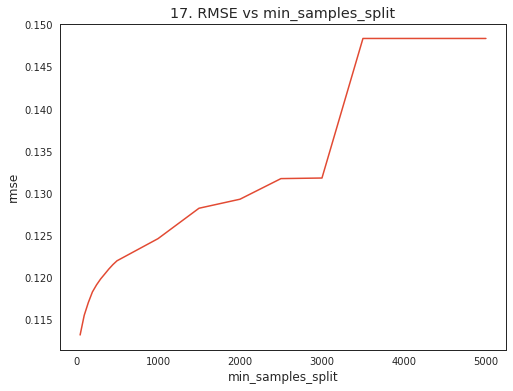

In [ ]:
# Creating the 20 models
min_samples_splits = [50 + i*50 for i in range(10)] + [500 + i*500 for i in range(10)]
models_min_samples_splits = [RandomForestRegressor(min_samples_split = min_samples_splits[i], random_state = 42) for i in range(20)]

min_samples_splits_rmses = []

# Fitting the models and making predictions
for model in models_min_samples_splits:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    min_samples_splits_rmses += [rmse]
    print(f"RMSE of model with min_samples_split={model.min_samples_split}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(min_samples_splits, min_samples_splits_rmses)
plt.title("17. RMSE vs min_samples_split")
plt.xlabel("min_samples_split")
plt.ylabel("rmse")
plt.show()

### Experiment 4: max_leaf_nodes

RMSE of model with max_leaf_nodes=200: 0.11172
RMSE of model with max_leaf_nodes=400: 0.10867
RMSE of model with max_leaf_nodes=600: 0.10694
RMSE of model with max_leaf_nodes=800: 0.10562
RMSE of model with max_leaf_nodes=1000: 0.10499
RMSE of model with max_leaf_nodes=1200: 0.10497
RMSE of model with max_leaf_nodes=1400: 0.10497
RMSE of model with max_leaf_nodes=1600: 0.10497
RMSE of model with max_leaf_nodes=1800: 0.10497
RMSE of model with max_leaf_nodes=2000: 0.10497


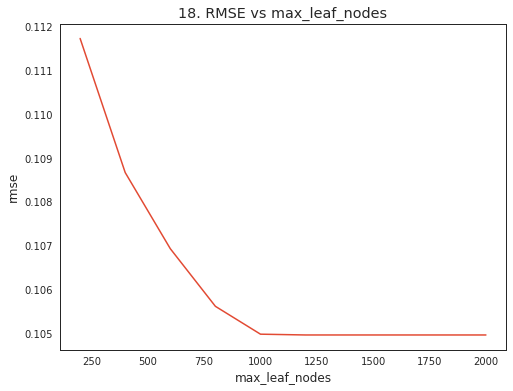

In [ ]:
# Creating the 10 models
max_leaf_nodes = [200 + i*200 for i in range(10)]
models_max_leaf_nodes = [RandomForestRegressor(max_leaf_nodes = max_leaf_nodes[i], random_state = 42) for i in range(10)]

max_leaf_nodes_rmses = []

# Fitting the models and making predictions
for model in models_max_leaf_nodes:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    max_leaf_nodes_rmses += [rmse]
    print(f"RMSE of model with max_leaf_nodes={model.max_leaf_nodes}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(max_leaf_nodes, max_leaf_nodes_rmses)
plt.title("18. RMSE vs max_leaf_nodes")
plt.xlabel("max_leaf_nodes")
plt.ylabel("rmse")
plt.show()

### Experiment 5: "min_samples_leaf"
В этом эксперименте вместо создания 10 моделей мы создадим 20 моделей для повышения точности.

RMSE of model with min_samples_leaf=25: 0.11514
RMSE of model with min_samples_leaf=50: 0.11717
RMSE of model with min_samples_leaf=75: 0.11864
RMSE of model with min_samples_leaf=100: 0.11974
RMSE of model with min_samples_leaf=125: 0.12069
RMSE of model with min_samples_leaf=150: 0.12144
RMSE of model with min_samples_leaf=175: 0.12194
RMSE of model with min_samples_leaf=200: 0.12265
RMSE of model with min_samples_leaf=225: 0.12312
RMSE of model with min_samples_leaf=250: 0.12339
RMSE of model with min_samples_leaf=250: 0.12339
RMSE of model with min_samples_leaf=500: 0.12487
RMSE of model with min_samples_leaf=750: 0.12882
RMSE of model with min_samples_leaf=1000: 0.13016
RMSE of model with min_samples_leaf=1250: 0.13278
RMSE of model with min_samples_leaf=1500: 0.13348
RMSE of model with min_samples_leaf=1750: 0.14838
RMSE of model with min_samples_leaf=2000: 0.14838
RMSE of model with min_samples_leaf=2250: 0.14838
RMSE of model with min_samples_leaf=2500: 0.14838


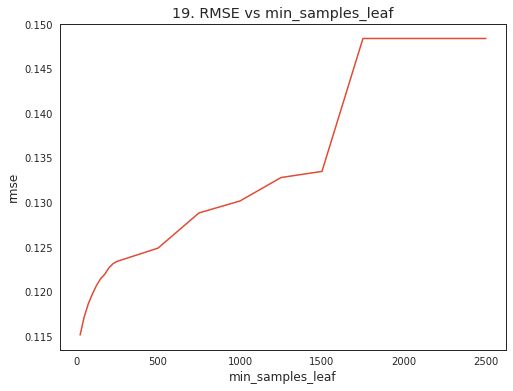

In [ ]:
# Creating the 20 models
min_samples_leaves =  [25 + i*25 for i in range (10)] + [250 + i*250 for i in range(10)]
models_min_samples_leaves = [RandomForestRegressor(min_samples_leaf = min_samples_leaves[i], random_state = 42) for i in range(20)]

min_samples_leaves_rmses = []

# Fitting the models and making predictions
for model in models_min_samples_leaves:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    min_samples_leaves_rmses += [rmse]
    print(f"RMSE of model with min_samples_leaf={model.min_samples_leaf}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(min_samples_leaves, min_samples_leaves_rmses)
plt.title("19. RMSE vs min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("rmse")
plt.show()

### Experiment #6: "max_samples"

RMSE of model with max_samples=0.05: 0.11707
RMSE of model with max_samples=0.099: 0.11406
RMSE of model with max_samples=0.14800000000000002: 0.11351
RMSE of model with max_samples=0.197: 0.11191
RMSE of model with max_samples=0.246: 0.11037
RMSE of model with max_samples=0.295: 0.10992
RMSE of model with max_samples=0.34400000000000003: 0.10932
RMSE of model with max_samples=0.393: 0.10854
RMSE of model with max_samples=0.442: 0.10848
RMSE of model with max_samples=0.491: 0.10851
RMSE of model with max_samples=0.54: 0.10731
RMSE of model with max_samples=0.5890000000000001: 0.10769
RMSE of model with max_samples=0.6380000000000001: 0.10687
RMSE of model with max_samples=0.687: 0.10649
RMSE of model with max_samples=0.7360000000000001: 0.10559
RMSE of model with max_samples=0.785: 0.10627
RMSE of model with max_samples=0.8340000000000001: 0.10584
RMSE of model with max_samples=0.8830000000000001: 0.10530
RMSE of model with max_samples=0.932: 0.10544
RMSE of model with max_samples=0.98

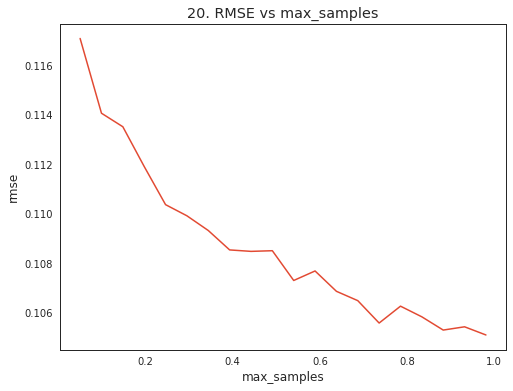

In [ ]:
# Creating the 20 models
max_samples =  [0.05 + i*0.049 for i in range(20)]
models_max_samples = [RandomForestRegressor(max_samples = max_samples[i], random_state = 42) for i in range(20)]

max_samples_rmses = []

# Fitting the models and making predictions
for model in models_max_samples:                   
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = get_rmse(y_test, predictions)
    max_samples_rmses += [rmse]
    print(f"RMSE of model with max_samples={model.max_samples}: {rmse:.5f}")

# Plotting the RMSEs
plt.plot(max_samples, max_samples_rmses)
plt.title("20. RMSE vs max_samples")
plt.xlabel("max_samples")
plt.ylabel("rmse")
plt.show()

В соответствии с приведенными выше результатами мы построим окончательную модель с параметрами, которые дали нам наилучшие результаты. Судя по приведенному выше графику, лучшими параметрами являются:

In [ ]:
best_n_estimators = 450
best_max_depth = 20
best_min_samples_split = 2
best_max_leaf_nodes = 1000
best_min_samples_leaf = 1
best_max_samples = 0.9810000000000001

print(f"Best n_estimators: {best_n_estimators}\nBest max_depth: {best_max_depth}\nBest min_samples_split: {best_min_samples_split}\nBest max_leaf_nodes: {best_max_leaf_nodes}\nBest min_samples_leaf: {best_min_samples_leaf}\nBest max_samples: {best_max_samples}")

Best n_estimators: 450
Best max_depth: 20
Best min_samples_split: 2
Best max_leaf_nodes: 1000
Best min_samples_leaf: 1
Best max_samples: 0.9810000000000001


## 5.2 Разработка и обучение оптимизированной модели на основе GridSearchCV

Далее проверим найденные оптимальные параметры с помощью алгоритма GridSearchCV. В соответствии с общим диапазоном каждого параметра, который мы проверили, мы соответственно выбрали 3 разных параметра.

In [ ]:
# Defining the optional values for each parameter
param_grid = {'n_estimators': [100, 300, 500],
              'max_depth': [20, 30, 40],
              'min_samples_split': [2, 500, 1000],
              'max_leaf_nodes': [333, 666, 1000],
              'min_samples_leaf': [1, 50, 100],
              'max_samples': [0.33,0.66,0.9810000000000001]}

# Using the GridSearchCV algorithm
best_model = model_selection.GridSearchCV(estimator = RandomForestRegressor(),
                                          param_grid = param_grid,
                                          scoring = 'neg_root_mean_squared_error',
                                          verbose=0,
                                          n_jobs=-1,
                                          cv=5)

best_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_leaf_nodes': [333, 666, 1000],
                         'max_samples': [0.33, 0.66, 0.9810000000000001],
                         'min_samples_leaf': [1, 50, 100],
                         'min_samples_split': [2, 500, 1000],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error')

Теперь покажем результат работы алгоритма GridSearchCV, и увидим, какой параметр выбрать для моделирования

In [ ]:
from pprint import pprint

In [ ]:
# Extracting the best parameters the algorithm has found
params = best_model.get_params()
pprint(params)

{'cv': 5,
 'error_score': nan,
 'estimator': RandomForestRegressor(),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'n_jobs': -1,
 'param_grid': {'max_depth': [20, 30, 40],
                'max_leaf_nodes': [333, 666, 1000],
                'max_samples': [0.33, 0.66, 0.9810000000000001],
                'min_samples_leaf': [1, 50, 100],
                'min_samples_split': [2, 500, 1000],
                'n_estimators': [100, 300, 500]},
 'pre_dispatch': '2

### 6. Создание двух окончательных моделей и их сравнение друг с другом

Для сравнения мы запустим агоритм RandomForest для модели, которую мы выбрали для создания, и для модели, которую мы создали в соответствии с алгоритмом GridSearch, и посмотрим на различия, если они есть. *Наша проверка будет проводиться в соответствии с критерием оптимальности - RMSE

In [ ]:
#Running Random Forest Algorithm with the best 
#parameters, according to the RMSE's graphs we've
#created only
best_model = RandomForestRegressor(max_depth= 40,
 max_leaf_nodes= 1000,
 max_samples= 0.9810000000000001,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 450,
 random_state= 42)

best_model.fit(X_train, y_train)
best_predictions = best_model.predict(X_test)
best_rmse_model1 = get_rmse(y_test, best_predictions)
print(f"RMSE of the optimized model according to our manual check: {best_rmse_model1:.5f}")


# Running Random Forest Algorithm with the best 
# parameters,recommended by the GridSearch algorithm
best_model = RandomForestRegressor(bootstrap= True,
 ccp_alpha= 0.0,
 criterion='mse',
 max_depth=None,
 max_features='auto',
 max_leaf_nodes= None,
 max_samples= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 100,
 n_jobs= None,
 oob_score= False,
 random_state= 42,
 verbose =0,
 warm_start =False)

best_model.fit(X_train, y_train)
best_predictions_grid = best_model.predict(X_test)
best_rmse_model2 = get_rmse(y_test, best_predictions_grid)
print(f"RMSE of the optimized model according to GridSearchCV algorithm: {best_rmse_model2:.5f}")

RMSE of the optimized model according to our manual check: 0.10452


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


RMSE of the optimized model according to GridSearchCV algorithm: 0.10542


### 7. Вывод из набора "скоров" моделей

Оценим нашу модель, используя расчет oob_score, и посмотрим, насколько она хороша.

In [ ]:
accuracy = best_model.score(X_train, y_train)
accuracy_test = best_model.score(X_test, best_predictions)

print('Accuracy for Random Forest using the train set',100*accuracy)
print('Accuracy for Random Forest using the test set',100*accuracy_test)






Accuracy for Random Forest using the train set 93.18934512377133
Accuracy for Random Forest using the test set 98.68975891109632


### Оценка результатов данных (после проверки)

In [ ]:
accuracy_model1 = (1 - best_rmse_model1)
accuracy_model2 = (1 - best_rmse_model2)

print('Accuracy according to RMSE for Random Forest',100*accuracy_model1)
print('Accuracy according to RMSE for Random Forest using the results of GridSearchCV',100*accuracy_model2)

Accuracy according to RMSE for Random Forest 89.54798685264807
Accuracy according to RMSE for Random Forest using the results of GridSearchCV 89.4579790575403


### Таким образом, точность первой модели немного больше, чем второй